In [34]:
import os
import cv2
import json
import numpy as np
import itertools
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Set dataset paths
AUTHENTIC_DIR = "CASIA2/Au"
TAMPERED_DIR = "CASIA2/Tp"
IMG_SIZE = (128, 128)  # Resize images for CNN input

In [16]:
# Function to apply Error Level Analysis (ELA)
def apply_ela(image_path, quality=90):
    original = Image.open(image_path).convert('RGB')
    temp_path = "temp.jpg"
    original.save(temp_path, 'JPEG', quality=quality)
    compressed = Image.open(temp_path)
    diff = ImageChops.difference(original, compressed)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    return np.array(diff.resize(IMG_SIZE))

In [23]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

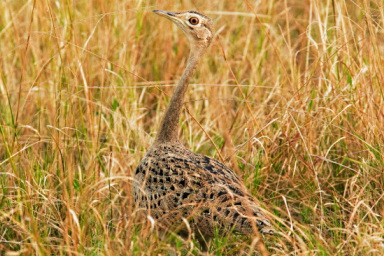

In [17]:
real_image_path = 'CASIA2/Au/auth_0114.jpg'
Image.open(real_image_path)

In [18]:
apply_ela(real_image_path, 90)

array([[[32, 18, 26],
        [14, 11, 54],
        [20, 13, 56],
        ...,
        [15, 13, 13],
        [16,  9, 14],
        [12, 11, 25]],

       [[34,  7, 19],
        [39, 13, 35],
        [32, 10, 22],
        ...,
        [14, 12, 13],
        [11, 12, 15],
        [ 8,  8, 18]],

       [[32,  8, 18],
        [47, 15, 47],
        [38, 16, 35],
        ...,
        [17, 15, 19],
        [26, 23, 23],
        [19, 24, 26]],

       ...,

       [[21,  9, 24],
        [47, 23, 18],
        [19, 18, 80],
        ...,
        [66, 23, 80],
        [28, 17, 54],
        [ 8, 15, 35]],

       [[21, 21, 29],
        [64, 38, 31],
        [48, 25, 50],
        ...,
        [57, 22, 42],
        [33, 20, 56],
        [19, 10, 27]],

       [[45, 36, 25],
        [51, 31, 24],
        [38, 23, 25],
        ...,
        [32, 16, 52],
        [44, 20, 50],
        [47, 18, 32]]], dtype=uint8)

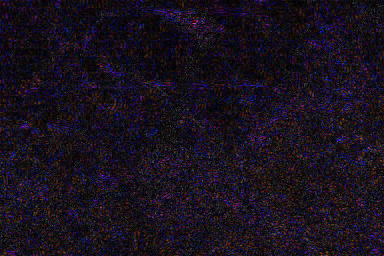

In [24]:
convert_to_ela_image(real_image_path, 90)

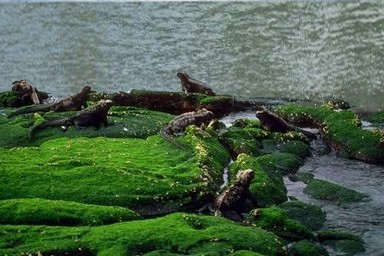

In [19]:
fake_image_path = 'CASIA2/Tp/tempp_0001.tif'
Image.open(fake_image_path)

In [20]:
apply_ela(fake_image_path, 90)

array([[[17, 13, 35],
        [23, 17, 44],
        [21, 27, 23],
        ...,
        [19, 20, 35],
        [26, 28, 29],
        [12,  9, 41]],

       [[12, 14, 28],
        [10, 11, 33],
        [14, 17, 25],
        ...,
        [25, 23, 36],
        [27, 25, 37],
        [11, 12, 26]],

       [[17, 17, 12],
        [13, 15, 16],
        [15, 10, 15],
        ...,
        [15, 16, 20],
        [13, 11, 19],
        [11, 11, 20]],

       ...,

       [[ 0,  4, 14],
        [ 3,  5, 16],
        [12,  6, 18],
        ...,
        [ 0,  0,  0],
        [ 2,  2,  2],
        [ 1,  1,  1]],

       [[ 0,  5, 18],
        [ 1,  7,  7],
        [ 2, 11,  7],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[ 0,  4, 12],
        [ 0,  4,  7],
        [ 1,  7, 16],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 2,  2,  2]]], dtype=uint8)

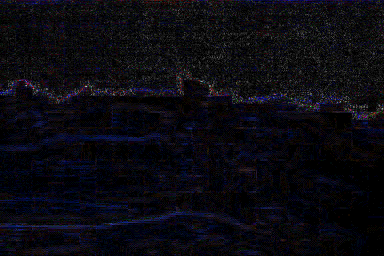

In [25]:
convert_to_ela_image(fake_image_path, 90)

In [21]:
# Load dataset with ELA
def load_dataset():
    images, labels = [], []
    for category, label in [(AUTHENTIC_DIR, 0), (TAMPERED_DIR, 1)]:
        for file in os.listdir(category):
            img_path = os.path.join(category, file)
            if img_path.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tif')):
                ela_img = apply_ela(img_path)
                images.append(ela_img)
                labels.append(label)
    return np.array(images) / 255.0, np.array(labels)

In [22]:
# Load data
X, y = load_dataset()
X = X.reshape(-1, 128, 128, 3)  # Reshape for CNN input

In [26]:
# Split into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

c:\Users\Nikhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Train Model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 201s 633ms/step - accuracy: 0.9067 - loss: 0.2289 - val_accuracy: 0.8894 - val_loss: 0.2768
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 221s 699ms/step - accuracy: 0.9185 - loss: 0.1946 - val_accuracy: 0.8989 - val_loss: 0.2644
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 254s 803ms/step - accuracy: 0.9171 - loss: 0.1914 - val_accuracy: 0.9017 - val_loss: 0.2556
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 240s 758ms/step - accuracy: 0.9243 - loss: 0.1737 - val_accuracy: 0.9041 - val_loss: 0.3032
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 200s 634ms/step - accuracy: 0.9221 - loss: 0.1724 - val_accuracy: 0.8997 - val_loss: 0.2831
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 195s 617ms/step - accuracy: 0.9278 - loss: 0.1599 - val_accuracy: 0.8969 - val_loss: 0.2739
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 187s 588ms/step - accuracy: 0.9298 - loss: 0.1544 - val_accuracy: 0.9001 - val_loss: 0.3165
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 182s 577ms/step - accuracy: 0.9343 -

In [41]:
# Save Model
model.save("trained_model.h5")

In [35]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step


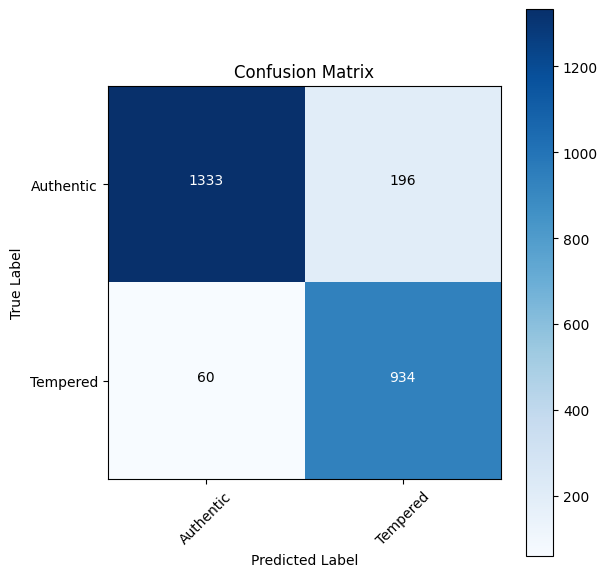

In [36]:

# Compute confusion matrix
y_pred = (model.predict(X_val) > 0.5).astype("int32")
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, classes=["Authentic", "Tempered"])


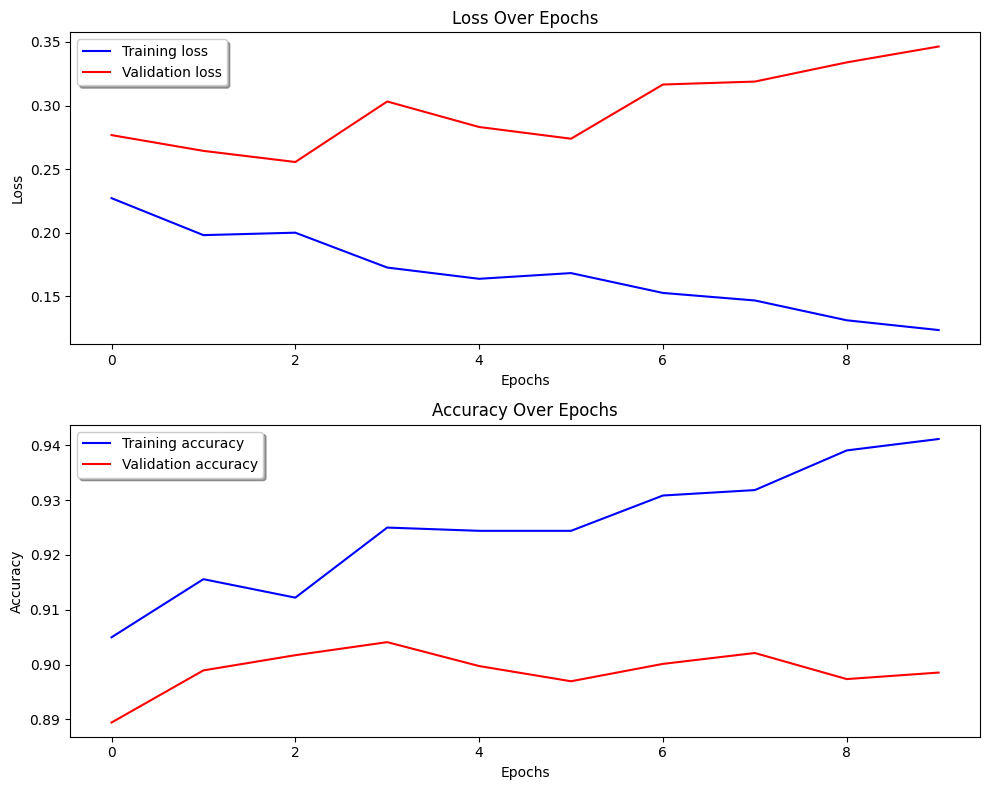

In [49]:

# Plot training & validation loss/accuracy
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot Loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(loc='best', shadow=True)

# Plot Accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title("Accuracy Over Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [44]:
import json

accuracy_data = {
    "train_accuracy": history.history['accuracy'][-1],  # Last epoch accuracy
    "validation_accuracy": history.history['val_accuracy'][-1],  # Last epoch val accuracy
    "train_loss": history.history['loss'][-1],  # Last epoch loss
    "validation_loss": history.history['val_loss'][-1]  # Last epoch val loss
}

with open("accuracy.json", "w") as json_file:
    json.dump(accuracy_data, json_file, indent=4)

print("Model accuracy saved in accuracy.json")

Model accuracy saved in accuracy.json


In [43]:
print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Train Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

Train Accuracy: 0.9411356449127197
Validation Accuracy: 0.8985334634780884
Train Loss: 0.12354876846075058
Validation Loss: 0.3463910222053528


In [31]:
# Function to predict and visualize forgery
def detect_forgery(image_path):
    ela_img = apply_ela(image_path) / 255.0
    ela_img = np.expand_dims(ela_img, axis=0)  # Add batch dimension
    prediction = model.predict(ela_img)[0][0]
    label = "Tempered" if prediction > 0.5 else "Authentic"
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


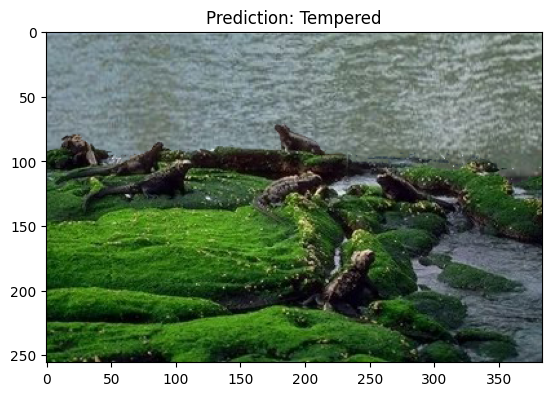

In [32]:
# Test on a sample image
detect_forgery("CASIA2/Tp/tempp_0001.tif")

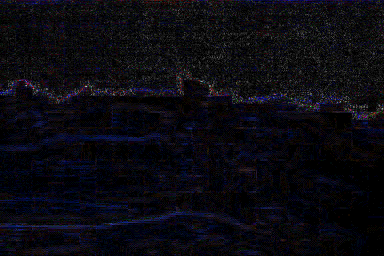

In [45]:
convert_to_ela_image("CASIA2/Tp/tempp_0001.tif",90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


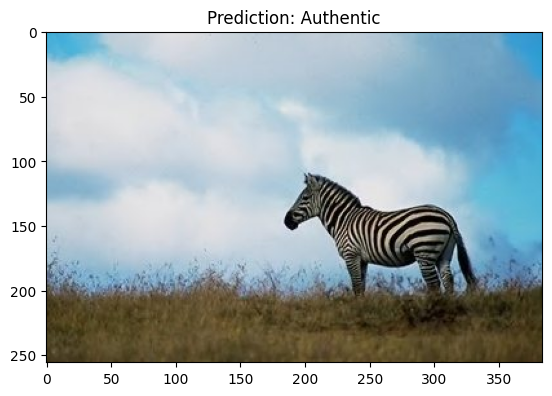

In [47]:
detect_forgery("CASIA2/Au/auth_0002.jpg")

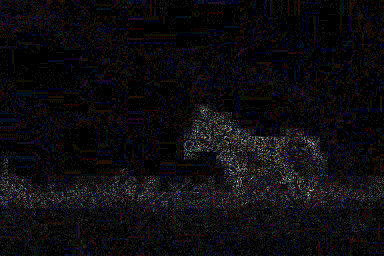

In [50]:
convert_to_ela_image("CASIA2/Au/auth_0002.jpg",90)